<a href="https://colab.research.google.com/github/choiiiiii/stan/blob/master/20Stan_golf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path

# Predator-Prey Population Dynamics: the Lotka-Volterra model in Stan


<a href = '#Data:-Lynx-and-Hare-Pelts-in-Canada'>Data: Lynx and Hare Pelts in Canada</a>

<a href = '#Mechanistic-Model:-The-Lotka-Volterra-Equations'>Mechanistic Model: The Lotka-Volterra Equations</a>

<a href = '#Statistical-Model:-Prior-Knowledge-and-Unexplained-Variation'>Statistical Model: Prior Knowledge and Unexplained Variation</a>

<a href = '#Coding-the-Model:-Stan-Program'>Coding the Model: Stan Program</a>

<a href = '#Solving-the-Inverse-Problem'>Solving the Inverse Problem: Bayesian Inference in Stan</a>

<a href = '#Conclusion:-What-are-the-Population-Dynamics?'>Conclusion: What are the Population Dynamics?</a>

<a href = '#Exercises-and-Extensions'>Exercises and Extensions</a>

Abstract

Lotka (1925) and Volterra (1926) formulated parameteric differential equations that characterize the oscillating populations of predators and prey. A statistical model to account for measurement error and unexplained variation uses the deterministic solutions to the Lotka-Volterra equations as expected population sizes. Stan is used to encode the statistical model and perform full Bayesian inference to solve the inverse problem of inferring parameters from noisy data. The model is fit to Canadian lynx11 Predator: Canadian lynx Canadian lynx© 2009, Keith Williams, CC-BY 2.0 and snowshoe hare22 Prey: snowshoe hare snowshoe hare© 2013, D. Gordon E. Robertson, CC-BY SA 3.0 populations between 1900 and 1920, based on the number of pelts collected annually by the Hudson’s Bay Company. Posterior predictive checks for replicated data show the model fits this data well. Full Bayesian inference may be used to estimate future (or past) populations.

## Data: Lynx and Hare Pelts in Canada

The species of interest in this case study are

- snowshoe hares, an hervivorous cousin of rabbits, and
- Canadian lynxes, a feline predator whose diet consists largely of snowshoe hares.

Rogers (2011) writes about the long history of population dynamics,

> *The rise and fall in numbers of snowshoe hares and Canada lynx was observed more than two hundred years ago by trappers working for Hudson’s Bay Company, which was once heavily involved in the fur trade. In the early 20th century, records of the number of lynx and hare pelts traded by Hudson’s Bay were analyzed by biologist Charles Gordon Hewitt.*

Following up on the original source, Hewitt (1921) provides plots of the number of pelts collected by the Hudson’s Bay Company, the largest fur trapper in Canada, between the years of 1821 and 1914.33 Graph from (Hewitt 1921) showing the numbers of pelts captured by the Hudson’s Bay Company. The fluctuations are irregular and the linear growth in rabbits after 1830 appears to be an artifact of interpolation. © Scribner’s Sons 1921 Hewitt’s discussion ranges over many natural factors affecting the population sizes, such as plagues, migrations, and weather-related events. Hewitt even discusses measurement confounders such as the fact that lynx are easier to trap when they are hungry and weak, which is correlated with a relative decline in the hare population. The models we consider here for illustrative purposes will not consider any of these factors, though they could be extended to do so through the usual strategy of the inclusion of covariates (see the exercises). Hewitt also discusses many other species; hares and lynxes occupy only a small part of a single chapter.

Howard (2009) provides numerical data for the number of pelts collected by the Hudson’s Bay Company in the years 1900-1920, which we have included in comma-separated value (CSV) form in the source repository with the case study.

In [2]:
lynx_hare_df = pd.read_csv('hudson-bay-lynx-hare.csv')
pd.melt(lynx_hare_df, id_vars = 'Year').iloc[[0,1,20,21,40,41]].rename(columns = {'variable':'species', 'value':'pelts in thousands'})


,Year,species,pelts in thousands
0,1900,Lynx,4.0
1,1901,Lynx,6.1
20,1920,Lynx,8.6
21,1900,Hare,30.0
40,1919,Hare,16.2
41,1920,Hare,24.7


The plot makes it clear that the spikes in the lynx population lag those in the hare population. When the populations are plotted against one another over time, the population dynamics orbit in an apparently stable pattern. Volterra (1926) recognized that these population oscillations could be modeled with a pair of differential equations similar to that used to describe springs.

In [3]:
lynx_hare_df.columns

Index(['Year', 'Lynx', 'Hare'], dtype='object')

[Text(0, 0.5, 'pelt (thousands)'), Text(0.5, 0, 'year')]

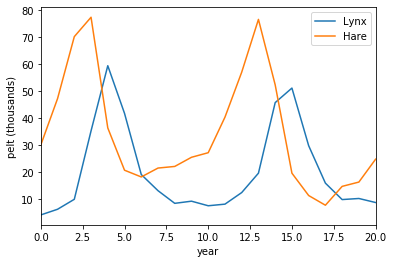

In [4]:
ax = lynx_hare_df.loc[:, ['Lynx', 'Hare']].plot()
ax.set(xlabel='year', ylabel='pelt (thousands)')

Plot of the number of lynx and hare pelts (in thousands) collected by the Hudson’s Bay Company between 1900 and 1920.

Text(0, 0.5, 'hare pelts (thousands)')

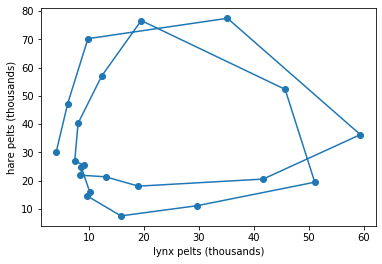

In [5]:
plt.scatter(lynx_hare_df.loc[:, 'Lynx'], lynx_hare_df.loc[:, 'Hare'])
plt.plot(lynx_hare_df.loc[:, 'Lynx'], lynx_hare_df.loc[:, 'Hare'])
plt.xlabel('lynx pelts (thousands)')
plt.ylabel('hare pelts (thousands)')

Plot of the number of pelts collected for lynx versus hares from 1900 to 1920. This plot is similar to that of the dynamics of a spring in phase space (i.e., position vs. momentum).

## Mechanistic Model: The Lotka-Volterra Equations

The Lotka-Volterra equations (Lotka 1925; Volterra 1926, 1927) are based on the assumptions that

- the predator population intrinsically shrinks,
- the prey population intrinsically grows,
- a larger prey population leads to a larger predator population, and
- a larger predator population leads to a smaller prey population.

More specifically, the rate of growth of the prey population is proportional to the size of the prey population, leading to exponential growth if unchecked. The prey population simultaneously shrinks at a rate proportional to the size of the product of the prey and predator populations. For the predator species, the direction of growth is reversed. The predator population shrinks at a rate proportional to its size and grows at a rate proportional to the product of its size and the prey population’s size.

Together, these dynamics lead to a cycle of rising and falling populations. With a low lynx population, the hare population grows. As the hare population grows, it allows the lynx population to grow. Eventually, the lynx population is large enough to start cutting down on the hare population. That in turn puts downward pressure on the lynx population. The cycle then resumes from where it started.

The Lotka-Volterra equations (Volterra 1926, 1927; Lotka 1925) are a pair of first-order, ordinary differential equations (ODEs) describing the population dynamics of a pair of species, one predator and one prey.

* u(t)≥0 is the population size of the prey species at time t, and
* v(t)≥0 is the population size of the predator species.

Volterra modeled the temporal dynamics of the two species (i.e., population sizes over times) in terms of four parameters, $\alpha, \beta, \gamma, \delta \geq 0$, as

$$
\begin{eqnarray}
\frac{\mathrm{d}}{\mathrm{d}t} u
& = &  (\alpha - \beta v) u
& = & \alpha u - \beta u v
\\[6pt]
\frac{\mathrm{d}}{\mathrm{d}t} v
& = &  (-\gamma + \delta \, u) \, v
& = & -\gamma v + \delta uv
\end{eqnarray}
$$

As usual in writing differential equations, $u(t)$ and $v(t)$ are rendered as $u$ and $v$ to simplify notation.  The factor $\alpha$ is the growth rate of the prey population, whereas $\beta$ is the rate of shrinkage relative to the product of the population sizes.  The factor $\gamma$ is the shrinkage rate of the predator population and $\delta$ is the growth rate of the predator population as a factor of the product of the population sizes.


### Positivitity constraint and extinction

As measures of population sizes, the values of $u(t)$ and $v(t)$ must be non-negative. Nothing in the differential equations here explicitly enforces positivity.  Nevertheless, as long as the initial populations are non-negative, i.e., $u(0) \geq 0$ and $v(0) \geq 0$, the values $u(t)$ and $v(t)$ for other times $t$ must also be non-negative.
This is because the rate of change in each population is a factor of the population size itself.

Although a population following the Lotka-Volterra dynamics will never become extinct,1682, Sir Thomas Herbert, public domain.</span>]  it may become arbitrarily small.   In reality, random events such as accidents can cause extinction events as can not so random events such as extensive hunting.  Therefore, the Lotka-Volterra model should not be expected to adequately model the dynamics of small populations.


### Behavior in the limit

One way to understand systems of equations is to consider their limiting behavior.  In this case, there are four behaviors, falling in two broad classes.

1. If both population sizes are initially positive, the populations will oscillate in a fixed pattern indefinitely, remaining positive.
2. If both population sizes are initially zero, the population sizes will remain zero.
3. If the predator population size is zero and the prey population size positive, the predator population size remains zero and the prey population grows without bound.
4. If the predator population size is positive and the prey population size zero, the prey population size remains zero while the predator population shrinks toward zero size (i.e., it asymptotes at zero).


## Statistical Model: Prior Knowledge and Unexplained Variation

### Solving the inverse problem

For a given legal value of the model parameters and initial state,  the Lotka-Volterra model predicts population dynamics into the future (and into the past).  But given noisy data about population dynamics, how do we solve the inverse problem, that of inferring the values of model parameters consistent with the data?  The general approach in Bayesian statistics is somewhat counterintuitive, as it involves formulating the forward model then using general principles to solve the inverse problem.

Specifically, a Bayesian model requires a mathematical model of what we know about the parameters (i.e., a prior) and a model of what we know about the data generating process given the parameters (i.e., a sampling distribution).
Mathematically, a prior density $p(\theta)$ over the sequence of parameters $\theta$ encapsulates our knowledge of the parameters before seeing the data.  A sampling distribution, which may have a continuous, discrete or mixed probability function, $p(y | \theta)$ characterizes the distribution of observable data $y$ given parameters $\theta$.

Bayes's rule gives us a general solution to the inverse problem, expressing the posterior $p(\theta | y)$ in terms of the prior $p(\theta)$ and likelihood $p(y | \theta)$.

Stan provides a form of Markov chain Monte Carlo (MCMC) sampling that draws a sample $\theta^{(1)}, \ldots, \theta^{(M)}$ from the posterior to use for computational inference. Posterior quantities of interest may be expressed as derived random variables using functions $f(\theta)$ of parameters. Such functions may be used for posterior expectation calculations such as parameter estimates that minimize expected square error when $f(\theta) = \theta$, or event probabilities such as the probability of the hare population falling below some fraction of the lynx population, when $f(\theta)$ is some indicator function. 

### Measurement Error and Unexplained Variation

The Lotka-Volterra model is deterministic.  Given the system parameters and the initial conditions, the solutions to the equations are fully determined.  Population measurements are not so well behaved that they exactly follow the model; there is residual, unexplained variation, as well as measurement error.

There are factors that impact predator and prey population size other than the current population size.  There are variable environmental effects, such as weather, which will vary from season to season and year to year and affect population sizes.  Infectious diseases occasionally spread through a population, reducing its size (Hewitt 1921).  There are also more long-term environmental factors such as carrying capacity.
In addition to factors that affect population which are not modeled, there is typically noise in the measurements. In this particular case, we cannot even measure the population directly.  Instead, pelts are used as a noisy proxy for population sizes. Hewitt (1921) further noted that animals are easier to trap when food is scarce, making the population measurements dependent on the population size.  Even the exact number of pelts taken is likely to be only approximate, as they were collected in a range of locations over an entire season.  Here, the number of pelts is rounded to the closest 100, building in measurement error on the order of 1%.

### A linear regression analogy

Like in a simple linear regression, we will proceed by treating the underlying determinstic model as providing an expected population value around which there will be variation due to both measurement error and simplifications in the scientific model.  Consider the typical formulation of a linear regression, where $y_n$ is an observable scalar outcome, $x_n$ is a row vector of unmodeled predictors (aka covariates, features), $\beta$ is a coefficient vector parameter, and $\sigma > 0$ is the error scale,

$$
\begin{eqnarray}
y_n & = & x_n \beta + \epsilon_n
\\[6pt]
\epsilon_n & \sim & \mathsf{Normal}(0, \sigma)
\end{eqnarray}
$$

The deterministic part of the equation is the linear predictor $x_n \beta$ with predictor $x_n$ (row $n$ of the data matrix $x$) and coefficient (column) vector $\beta$.  The stochastic error term, $\epsilon_n$, is assigned a normal distribution located at zero with scale parameter $\sigma > 0$. We typically formulate this model without the latent error variable $\epsilon_n$ as follows, 

$$
y_n \sim \mathsf{Normal}(x_n \beta, \sigma).
$$


### Lotka-Volterra error model

Solutions to the Lotka-Volterra equations replace the linear predictor $x_n \, \beta$, but we maintain the error term to compensate for measurement error and unexplained variation in the data.  In the case of population dynamics, the data $y_n$ consists of measurements of the prey $y_{n, 1}$ and predator $y_{n, 2}$ populations at times $t_n$.

The true population sizes at time $t = 0$ are unknown---we only have measurements $y^{\rm init}_1$ and $y^{\rm init}_2$ of them.  The true initial population sizes at time $t = 0$ will be represented by a parameter $z^{\mathrm init}$, so that

$$
\begin{array}{rcl}
z^{\mathrm init}_1 & = & u(t = 0)
\\[4pt]
z^{\mathrm init}_2 & = & v(t = 0).
\end{array}
$$

Next, let $z_1, \ldots, z_N$ be the solutions to the Lotka-Volterra differential equations at times $t_1, \ldots, t_N$ given initial conditions $z(t = 0) = z^{\mathrm init}$ and parameters $\theta = (\alpha, \beta, \gamma, \delta)$.  Each $z_n$ is a pair of prey and predator population sizes at the specified times,

$$
\begin{array}{rcl}
z_{n, 1} & = & u(t_n)
\\[4pt]
z_{n, 2} & = &  v(t_n).
\end{array}
$$

The $z_n$ are random variables, but they are deterministic functions of the random variables for the initial state $z^{\mathrm init}$ and system parameters $\alpha, \beta, \gamma, \delta$.

The observed data is in the form of measurements $y^{\rm init}$ of the initial population of prey and predators, and subsequent measurements $y_n$ of the populations at times $t_n$, where $y^{\mathrm init}$ and the $y_n$ consist of a pair of measured population sizes, for the prey and predator species.

In summary, the measurements, $y^{\rm init}$ and $y_n$, are drawn indepently from a normal distribution centered at the underlying population sizes, $z^{\rm init}$ and $z_n$, with noise scales $\sigma$.  Each quantity here, including the noise scale, is a pair consisting of values for prey and predator.

### Multiplicative error and the lognormal distribution

It is common to log transform positive-only parameters so that they are no longer constrained to be positive.  On the log scale, we can then take the error to be unconstrained and additive, just as in linear regression.

$$
\begin{eqnarray}
\log y_{n, k} & = & \log z_{n, k} + \epsilon_{n, k}
\\[6pt]
\epsilon_{n, k} & \sim & \mathsf{Normal}(0, \sigma_k)
\end{eqnarray}
$$

where the $z_n$ are the solutions to the Lotka-Volterra equations at times $t_1, \ldots, t_N$ given initial populations $z^{\mathrm init}$.  The prey and predator populations have error scales (on the log scale) of $\sigma_1$ and $\sigma_2$.


With additive errors on the log transformed scales, the result of transforming back to the natural scale (by exponentiation) leads to multiplicative errors,

$$
\begin{array}{rcl}
y_{n, k} & = & \exp(\log z_{n, k} + \epsilon_{n, k})
\\[4pt]
         & = & z_{n, k} \, \exp(\epsilon_{n,k})
\end{array}
$$

Because $\exp(\epsilon_{n,k})$ is positive and the underlying population size $z_{n,k}$ is positive, their product will be positive. In other words, rather than the measurement being plus or minus some value, it's plus or minus some percentage of the total.

This transform and its associated fractional error is so common that they are jointly known as the lognormal distribution, so that we can simplify the above notation as we did with linear regression and write

$$
y_{n, k} \sim \mathsf{LogNormal}(z_{n, k}, \sigma_n).
$$
whenever
$$
\log y_{n, k} \sim \mathsf{Normal}(z_{n, k}, \sigma_n).
$$
The $\mathsf{LogNormal}$ density accounts for the non-linear change of variables through a Jacobian adjustment.

### Weakly informative priors

Our only remaining task is to formulate what we know about the parameters as priors.  In general, we recommend at least weakly informative priors on parameters. In practice, weakly informative priors inform the scale of the answer, but have only a negligible effect on the exact value;  that is, they are not very sensitive by design.  While not being very sensitive, they help enormously to ease computation, as Stan might otherwise work very hard to explore the outskirts of gnarly, unregularized distributions. In order to formulate such priors, we need to know the rough scale on which to expect an answer.  Because this model is well understood and widely used, as is the basic behavior of predator and prey species such as lynxes and hares, the parameter ranges leading to stable and realistic population oscillations are well known.

### Priors for system parameters

For the parameters, recall that $\alpha$ and $\gamma$ are multipliers of $u$ and $-v$ respectively in the state equations, whereas $\beta$ and $\delta$ are multipliers of the product $u \, v$.  Combined with the fact that the scale of $u$ and $v$ are roughly 10 as the data has been encoded, we can formulate similar weakly informative priors,

$$
\begin{eqnarray}
\alpha, \gamma & \sim & \mathsf{Normal}(1, 0.5)
\\[6pt]
\beta, \delta & \sim & \mathsf{Normal}(0.05, 0.05)
\end{eqnarray}
$$

### Prior for noise scale

The noise scale is proportional, so the following prior should be weakly informative, as a value smaller than 0.05 or larger than 3 would be unexpected.

$$
\sigma \sim \mathsf{LogNormal}(-1, 1)
$$

Another reasonable prior choice would be a broad half normal.

## Coding the Model: Stan Program

### Coding the system dynamics

Whenever a general system of differential equations is involved, the system equations must be coded as a Stan function.  In this case, the model is relatively simple as the state is only two dimensional and there are only four parameters.  Stan requires the system to be defined with exactly the signature defined here for the function <code>dz_dt()</code>, even if not all of them are used.  The first argument is for time, which is not used here because the rates in the Lotka-Voltarra equations do not depend on time. The second argument is for the system state, coded as an array
$z = (u, v)$.  The third argument is for the parameters of the equation, of which the Lotka-Voltarra equations have four, which are coded as $\theta = (\alpha, \beta, \gamma, \delta)$.  The fourth and fifth argument are for data constants, but none are needed here, so these arguments are unused.

```
real[] dz_dt(real t, real[] z, real[] theta,
             real[] x_r, int[] x_i) {
  real u = z[1];
  real v = z[2];
  real alpha = theta[1];
  real beta = theta[2];
  real gamma = theta[3];
  real delta = theta[4];
  real du_dt = (alpha - beta * v) * u;
  real dv_dt = (-gamma + delta * u) * v;
  return { du_dt, dv_dt };
}
```

After unpacking the variables from their containers, the derivatives of population with respect to time are defined just as in the mathematical specification.  The return value uses braces to construct the two-element array to return, which consists of the derivatives of the system components with respect to time,

$$
\frac{\mathrm{d}}{\mathrm{d}t} z
\ = \ \frac{\mathrm{d}}{\mathrm{d}t} (u, v)
\ = \ \left( \frac{\mathrm{d}}{\mathrm{d}t} u, \, \frac{\mathrm{d}}{\mathrm{d}t} v \right).
$$

The data variables are coded following their specifications,

```
data {
  int<lower = 0> N;           // num measurements
  real ts[N];                 // measurement times > 0
  real y_init[2];             // initial measured population
  real<lower = 0> y[N, 2];    // measured population at measurement times
}
```

as are the parameters,

```
parameters {
  real<lower = 0> theta[4];   // theta = { alpha, beta, gamma, delta }
  real<lower = 0> z_init[2];  // initial population
  real<lower = 0> sigma[2];   // error scale
}
```

The solutions to the Lotka-Volterra equations for a given initial state $z^{\mathrm init}$ are defined as transformed parameters.  This will allow them to be used in the model and inspected in the output (as we do in later graphs).  It also makes it clear that they are all functions of the initial population and parameters (as well as the solution times).
```
transformed parameters {
  real z[N, 2]
    = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                         rep_array(0.0, 0), rep_array(0, 0),
                         1e-6, 1e-5, 1e3);
}
```

The required real and integer data arguments in the second line are both given as constant size-zero arrays.  The last line provides relative and absolute tolerances, along with the maximum number of steps allowed in the solver before rejecting. For further efficiency, the tolerances for the differential equation solver are relatively loose for this example; usually tighter tolerances are required (smaller numbers).

With the solutions in hand, the only thing left are the prior and likelihood.  As with the other parts of the model, these directly follow the notation in the mathematical specification.

```
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1:2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ , k] ~ lognormal(log(z[, k]), sigma[k]);
  }
}
```

The multiple indexing `theta[{1, 3}]` indicates that both `theta[1]` and `theta[3]` get the prior `normal(1, 0.5)`;  it is both more efficient and more compact to represent them this way.  The second sampling statement involving `y[ , k]` is vectorized and amounts to the same thing as an additional loop,

```
for (n in 1:N)
  y[n, k] ~ lognormal(log(z[n, k]), sigma[k])
```

As with the prior, the vectorized form used in the actual model block is much more efficient.  The `y_init` sampling statement could be pulled out of the loop, but there is not much efficiency gain as there are only two elements, so it is left in this form for clarity.





## Solving the Inverse Problem: Bayesian Inference in Stan

### Fitting the Hudson's Bay Company data

First, the data is munged into a form suitable for Stan.

In [6]:
N = lynx_hare_df.shape[0]
ts = np.arange(1, N + 1)
y_init = lynx_hare_df.loc[0, ['Hare', 'Lynx']]
y = lynx_hare_df.loc[1:, ['Hare', 'Lynx']]

## Conclusion: What are the Population Dynamics?

## Exercises and Extensions